In [2]:
import json
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

node_feat = np.load('/home/sgan/private/DyGLib/processed_data/bluesky/ml_bluesky_node.npy')

with open('recommended_posts.json', 'r') as file:
    data = json.load(file)

intra_list_distance = []

for d in data:
    top_30 = d[:10]
    top_30_features = node_feat[top_30]  # Extract their feature vectors
        
    # Compute cosine similarity between all pairs
    similarity_matrix = cosine_similarity(top_30_features)
    
    # Compute mean pairwise distance (1 - similarity)
    mean_distance = 1 - np.mean(similarity_matrix)
    
    intra_list_distance.append(mean_distance)

print(np.mean(intra_list_distance))

0.6566109393259277


In [2]:
import json
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Load node features
node_feat = np.load('/home/sgan/private/DyGLib/processed_data/bluesky/ml_bluesky_node.npy')

# Load recommended posts
with open('recommended_posts.json', 'r') as file:
    data = json.load(file)

# Initialize list to store ILD@k values
intra_list_distance = []
k = 10  # Set k for ILD@k

for d in data:
    top_k = d[:k]  # Get top-k recommended items
    top_k_features = node_feat[top_k]  # Extract their feature vectors
    
    # Compute cosine similarity between all pairs
    similarity_matrix = cosine_similarity(top_k_features)
    
    # Convert similarity to distance (1 - similarity)
    distance_matrix = 1 - similarity_matrix
    
    # Exclude diagonal (self-similarity) by using upper triangle only
    num_pairs = k * (k - 1)  # Number of unique pairs
    mean_distance = np.sum(distance_matrix) / num_pairs  # ILD@k formula
    
    intra_list_distance.append(mean_distance)

# Compute overall ILD@k
print("ILD@k:", np.mean(intra_list_distance))


ILD@k: 0.6299263327301661


In [9]:
interaction_df[interaction_df['ts']<1687549646.0]

,Unnamed: 0,u,i,ts,label,idx
0,0,12249,107717,1.672541e+09,0.0,1
1,1,50948,3150865,1.672541e+09,0.0,2
2,2,24219,2454231,1.672545e+09,0.0,3
3,3,13744,107717,1.672550e+09,0.0,4
4,4,50948,107717,1.672551e+09,0.0,5
...,...,...,...,...,...,...
18811679,18811679,81338,1850125,1.687550e+09,0.0,18811680
18811680,18811680,44694,889609,1.687550e+09,0.0,18811681
18811681,18811681,91179,128990,1.687550e+09,0.0,18811682
18811682,18811682,31432,1521986,1.687550e+09,0.0,18811683


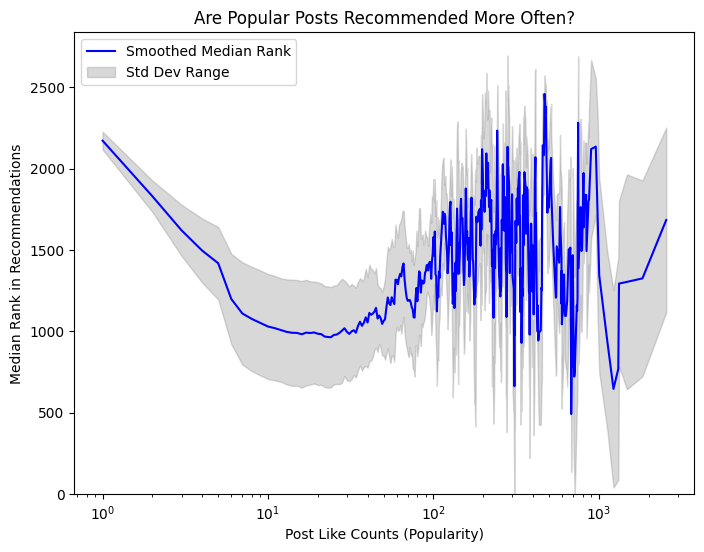

In [10]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

# Load recommended posts
with open('recommended_posts.json', 'r') as file:
    data = json.load(file)

# Load interaction data (post like counts)
interaction_df = pd.read_csv('/home/sgan/private/DyGLib/processed_data/bluesky/ml_bluesky.csv')
interaction_df = interaction_df[interaction_df['ts']<1687549646.0]
post_like_counts = interaction_df['i'].value_counts().to_dict()  # Convert to dictionary for fast lookup

# Create a DataFrame to store rankings
rankings = []
for user_recs in data:
    for rank, post_id in enumerate(user_recs, start=1):  # Rank starts from 1 (not 0)
        rankings.append((post_id, rank))

# Convert rankings into DataFrame
rank_df = pd.DataFrame(rankings, columns=['post_id', 'rank'])

# Compute statistics: median rank, std deviation per post
rank_stats = rank_df.groupby('post_id')['rank'].agg(['median', 'std']).reset_index()

# Merge with popularity data (fill missing counts with 0)
rank_stats['popularity'] = rank_stats['post_id'].map(post_like_counts).fillna(0)

# Group by popularity (aggregate posts with the same like count)
agg_rank_stats = rank_stats.groupby('popularity').agg(
    median_rank=('median', 'median'),
    std_rank=('std', 'median')
).reset_index()

# Extract values for plotting
popularity = agg_rank_stats['popularity']
median_rank = agg_rank_stats['median_rank']
std_dev = agg_rank_stats['std_rank'].fillna(0)  # Fill NaN std with 0 to avoid errors

# Apply smoothing with a rolling average (window=5)
median_rank_smoothed = median_rank.rolling(window=5, min_periods=1).mean()
std_dev_smoothed = std_dev.rolling(window=5, min_periods=1).mean()

# Plot line plot with smoothed curve
plt.figure(figsize=(8, 6))
plt.plot(popularity, median_rank_smoothed, linestyle='-', label="Smoothed Median Rank", color='blue')

# Add standard deviation shading
plt.fill_between(popularity, 
                 median_rank_smoothed - std_dev_smoothed, 
                 median_rank_smoothed + std_dev_smoothed, 
                 color='gray', alpha=0.3, label="Std Dev Range")

# Log scale for popularity
plt.xscale('log')

# Prevent y-axis from going below 0
plt.ylim(bottom=0)

# Labels and title
plt.xlabel('Post Like Counts (Popularity)')
plt.ylabel('Median Rank in Recommendations')
plt.title('Are Popular Posts Recommended More Often?')
plt.legend()

# Save the figure as PNG
plt.savefig('rank_vs_popularity.png', dpi=300, bbox_inches='tight')
plt.show()